## Índice
1. [Importación de librerías](#1-importación-de-librerías)
2. [Carga del dataset](#2-carga-del-dataset)
3. [Dividir el conjunto de datos](#3-dividir-el-conjunto-de-datos)
4. [Codificar variables categóricas](#4-codificar-variables-categóricas)
5. [Estandarizar las características](#5-estandarizar-las-características)
6. [Reducir la dimensionalidad del conjunto de datos](#6-reducir-la-dimensionalidad-del-conjunto-de-datos)


In [58]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Librerias

In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

#Dataset

In [60]:
bank = pd.read_csv('/content/drive/MyDrive/bank_dataset.csv')

In [61]:
bank.shape

(11162, 17)

# Limpieza y Transformacion

In [62]:
# Seleccionar solo las columnas numéricas
df_numerical = bank.select_dtypes(include=['number'])

def obtener_outliers_iqr(df):
    outliers_dict = {}  # Diccionario para almacenar los outliers de cada columna

    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filtrar los valores que son outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]

        # Almacenar los outliers en el diccionario
        outliers_dict[column] = outliers.tolist()

    return outliers_dict

# Obtener los outliers para cada variable numérica
outliers_por_variable = obtener_outliers_iqr(df_numerical)

# Imprimir los outliers de cada variable
for column, outliers in outliers_por_variable.items():
    print(f'Outliers en {column}: {outliers}')

Outliers en age: [75.0, 85.0, 90.0, 85.0, 83.0, 76.0, 83.0, 77.0, 77.0, 76.0, 78.0, 95.0, 78.0, 75.0, 76.0, 85.0, 83.0, 79.0, 82.0, 79.0, 75.0, 76.0, 82.0, 77.0, 86.0, 76.0, 79.0, 83.0, 77.0, 84.0, 83.0, 75.0, 77.0, 76.0, 77.0, 87.0, 76.0, 92.0, 78.0, 82.0, 76.0, 77.0, 76.0, 81.0, 75.0, 80.0, 87.0, 76.0, 82.0, 77.0, 76.0, 81.0, 75.0, 78.0, 80.0, 86.0, 79.0, 79.0, 81.0, 75.0, 84.0, 87.0, 85.0, 79.0, 92.0, 77.0, 81.0, 80.0, 77.0, 78.0, 76.0, 80.0, 77.0, 76.0, 75.0, 82.0, 80.0, 78.0, 90.0, 83.0, 80.0, 82.0, 80.0, 84.0, 86.0, 75.0, 76.0, 77.0, 76.0, 77.0, 80.0, 77.0, 78.0, 75.0, 84.0, 78.0, 80.0, 80.0, 79.0, 86.0, 93.0, 82.0, 82.0, 77.0, 93.0, 77.0, 75.0, 80.0, 84.0, 75.0, 78.0, 81.0, 81.0, 77.0, 78.0, 75.0, 77.0, 77.0, 77.0, 78.0, 77.0, 79.0, 78.0, 75.0, 80.0, 76.0, 78.0, 79.0, 75.0, 77.0, 79.0, 78.0, 88.0, 77.0, 85.0, 78.0, 80.0, 82.0, 75.0, 77.0, 78.0, 78.0, 76.0, 81.0, 77.0, 75.0, 80.0, 80.0, 80.0, 76.0, 77.0, 81.0, 76.0, 76.0, 87.0, 81.0, 78.0, 82.0, 83.0, 77.0, 77.0, 75.0, 76.0, 89.0

In [63]:
def remove_outliers(df, column, factor=3):  # Aumentamos el factor a 3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aplicamos el método con un factor de 3 en lugar de 1.5
bank = remove_outliers(bank, 'age', factor=3)
bank = remove_outliers(bank, 'balance', factor=3)
bank = remove_outliers(bank, 'duration', factor=3)
bank = remove_outliers(bank, 'pdays', factor=3)
bank = remove_outliers(bank, 'previous', factor=3)

def remove_outliers_percentiles(df, column, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aplicamos el método con percentiles del 1% al 99%
bank = remove_outliers_percentiles(bank, 'age')
bank = remove_outliers_percentiles(bank, 'balance')
bank = remove_outliers_percentiles(bank, 'duration')
bank = remove_outliers_percentiles(bank, 'pdays')
bank = remove_outliers_percentiles(bank, 'previous')


In [64]:
bank.shape

(5839, 17)

In [65]:
# Calcular la media de 'age' para cada combinación de 'job', 'marital', 'education', y 'balance'
age_mean = bank.groupby(['job', 'marital', 'education'])['age'].mean().reset_index(name='mean_age')

# Calcular la moda (la categoría más frecuente) de 'marital' para cada combinación
marital_mode = bank.groupby(['job', 'age', 'education'])['marital'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index(name='mode_marital')

# Calcular la moda de 'education' para cada combinación
education_mode = bank.groupby(['job', 'age', 'marital'])['education'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index(name='mode_education')

# Imputar la media para 'age'
for index, row in bank[bank['age'].isnull()].iterrows():
    mean_age = age_mean.loc[
        (age_mean['job'] == row['job']) &
        (age_mean['marital'] == row['marital']) &
        (age_mean['education'] == row['education']) , 'mean_age'
    ]

    if not mean_age.empty:
        bank.at[index, 'age'] = mean_age.values[0]

# Imputar la moda para 'education'
for index, row in bank[bank['education'].isnull()].iterrows():
    mode_education = education_mode.loc[
        (education_mode['job'] == row['job']) &
        (education_mode['age'] == row['age']) &
        (education_mode['marital'] == row['marital']), 'mode_education'
    ]

    if not mode_education.empty:
        bank.at[index, 'education'] = mode_education.values[0]

# Imputar la moda para 'marital'
for index, row in bank[bank['marital'].isnull()].iterrows():
    mode_marital = marital_mode.loc[
        (marital_mode['job'] == row['job']) &
        (marital_mode['age'] == row['age']) &
        (marital_mode['education'] == row['education']), 'mode_marital'
    ]

    if not mode_marital.empty:
        bank.at[index, 'marital'] = mode_marital.values[0]

In [66]:
# Verificar los valores nulos después de la imputación
print("Valores nulos en 'age' después de imputar:", bank['age'].isnull().sum())
print("Valores nulos en 'marital' después de imputar:", bank['marital'].isnull().sum())
print("Valores nulos en 'education' después de imputar:", bank['education'].isnull().sum())

Valores nulos en 'age' después de imputar: 0
Valores nulos en 'marital' después de imputar: 0
Valores nulos en 'education' después de imputar: 0


Porcentaje de depósitos: 35.45%
Porcentaje de no depósitos: 64.55%


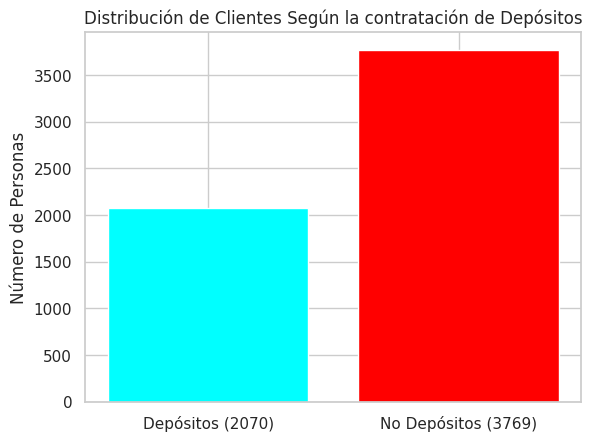

In [67]:
# Contar el número de suscripciones y no suscripciones en la variable 'deposit'
num_depositos = bank[bank['deposit'] == 'yes'].shape[0]
num_no_depositos = bank[bank['deposit'] == 'no'].shape[0]

total = num_depositos + num_no_depositos
percent_depositos = (num_depositos / total) * 100
percent_no_depositos = (num_no_depositos / total) * 100
print(f"Porcentaje de depósitos: {percent_depositos:.2f}%")
print(f"Porcentaje de no depósitos: {percent_no_depositos:.2f}%")

# Gráficas de barras
plt.bar(["Depósitos (%d)" % num_depositos, "No Depósitos (%d)" % num_no_depositos],
        [num_depositos, num_no_depositos],
        color=["cyan", "red"],
        width=0.8)

plt.ylabel("Número de Personas")
plt.title("Distribución de Clientes Según la contratación de Depósitos")
plt.show()

Al realizar el borrado de outliers nuestras clases han quedado con mayor desbalanceo, por lo que procedo a realizar un oversampler

In [68]:
# Características (X) y la variable objetivo (y)
X = bank.drop(columns=['deposit'])
y = bank['deposit']

# Inicializar el oversampler
ros = RandomOverSampler(random_state=42)

# Aplicar oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Convertir de nuevo a un DataFrame
bank_resampled = pd.DataFrame(X_resampled, columns=X.columns)
bank_resampled['deposit'] = y_resampled

# Verificar el nuevo balance de clases
num_depositos_resampled = bank_resampled[bank_resampled['deposit'] == 'yes'].shape[0]
num_no_depositos_resampled = bank_resampled[bank_resampled['deposit'] == 'no'].shape[0]

print("Número de depósitos después de oversampling:", num_depositos_resampled)
print("Número de no depósitos después de oversampling:", num_no_depositos_resampled)

# Verificar los porcentajes
total_resampled = num_depositos_resampled + num_no_depositos_resampled
percent_depositos_resampled = (num_depositos_resampled / total_resampled) * 100
percent_no_depositos_resampled = (num_no_depositos_resampled / total_resampled) * 100

print(f"Porcentaje de depósitos después de oversampling: {percent_depositos_resampled:.2f}%")
print(f"Porcentaje de no depósitos después de oversampling: {percent_no_depositos_resampled:.2f}%")

Número de depósitos después de oversampling: 3769
Número de no depósitos después de oversampling: 3769
Porcentaje de depósitos después de oversampling: 50.00%
Porcentaje de no depósitos después de oversampling: 50.00%


#Preparacion de los datos

###Division del conjunto de datos

Nos aseguramos de mantener el balance de las clases utilizando el comando stratify

In [69]:
# Definir X e Y
X = bank.drop('deposit', axis=1)  # Todas las columnas excepto 'deposit'
Y = bank['deposit']  # La variable objetivo 'deposit'

# Dividir los datos en conjuntos de entrenamiento y prueba (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

# Verificar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento (X): {X_train.shape}")
print(f"Tamaño del conjunto de prueba (X): {X_test.shape}")
print(f"Tamaño del conjunto de entrenamiento (Y): {Y_train.shape}")
print(f"Tamaño del conjunto de prueba (Y): {Y_test.shape}")

Tamaño del conjunto de entrenamiento (X): (4671, 16)
Tamaño del conjunto de prueba (X): (1168, 16)
Tamaño del conjunto de entrenamiento (Y): (4671,)
Tamaño del conjunto de prueba (Y): (1168,)


In [70]:
# Verificar la distribución de las clases
print("Distribución en el conjunto de entrenamiento:")
print(Y_train.value_counts(normalize=True))
print("Distribución en el conjunto de prueba:")
print(Y_test.value_counts(normalize=True))

Distribución en el conjunto de entrenamiento:
deposit
no     0.645472
yes    0.354528
Name: proportion, dtype: float64
Distribución en el conjunto de prueba:
deposit
no     0.645548
yes    0.354452
Name: proportion, dtype: float64


###Codificación variables categoricas

In [71]:
#Columnas Binarias
binary_columns = [ 'default', 'housing', 'loan']

# Aplicar Label Encoding a las columnas binarias
label_encoder = LabelEncoder()


for column in binary_columns:
    X_train[column] = label_encoder.fit_transform(X_train[column])
    X_test[column] = label_encoder.transform(X_test[column])  # Aplicar la misma transformación al conjunto de prueba
    print(f"Valores únicos en '{column}' después de Label Encoding: {X_train[column].unique()}\n")

X_train.head()

Valores únicos en 'default' después de Label Encoding: [0 1]

Valores únicos en 'housing' después de Label Encoding: [1 0]

Valores únicos en 'loan' después de Label Encoding: [1 0]



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
10739,38.0,management,married,secondary,0,3840,1,1,cellular,17,nov,62,1,-1,0,unknown
10860,33.0,admin.,married,secondary,0,2,1,0,unknown,20,may,201,1,-1,0,unknown
5413,39.0,technician,married,secondary,0,1,1,0,unknown,26,may,506,2,-1,0,unknown
281,56.0,blue-collar,married,secondary,0,1210,0,0,unknown,11,jun,935,1,-1,0,unknown
6116,35.0,blue-collar,married,primary,0,623,1,0,cellular,6,may,97,2,-1,0,unknown


In [72]:
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded_array_train = encoder.fit_transform(X_train[["poutcome", "marital", "education", "contact", "month", "job"]])
one_hot_encoded_array_test = encoder.transform(X_test[["poutcome", "marital", "education", "contact", "month", "job"]])

# Convertir de nuevo a DataFrame
one_hot_encoded_df_train = pd.DataFrame(one_hot_encoded_array_train, columns=encoder.get_feature_names_out(["poutcome", "marital", "education", "contact", "month", "job"]))
one_hot_encoded_df_test = pd.DataFrame(one_hot_encoded_array_test, columns=encoder.get_feature_names_out(["poutcome", "marital", "education", "contact", "month", "job"]))

# Concatenar las columnas codificadas a los DataFrames originales
X_train = pd.concat([X_train.reset_index(drop=True), one_hot_encoded_df_train.reset_index(drop=True)], axis=1).drop(["poutcome", "marital", "education", "contact", "month", "job"], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), one_hot_encoded_df_test.reset_index(drop=True)], axis=1).drop(["poutcome", "marital", "education", "contact", "month","job"], axis=1)

X_train.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,38.0,0,3840,1,1,17,62,1,-1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,33.0,0,2,1,0,20,201,1,-1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,39.0,0,1,1,0,26,506,2,-1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,56.0,0,1210,0,0,11,935,1,-1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35.0,0,623,1,0,6,97,2,-1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###Estandarizacion de datos

In [73]:
# Seleccionar las columnas numéricas
numerical_columns = ['age', 'balance', 'duration', 'pdays', 'campaign']

# Aplicar StandardScaler solo a esas columnas
scaler = StandardScaler()

# Ajustar el escalador solo en el conjunto de entrenamiento y transformar
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Aplicar la misma transformación al conjunto de prueba
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [74]:
X_train.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,-0.221897,0,3.175960,1,1,17,-1.065128,-0.599444,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.756773,0,-0.841116,1,0,20,-0.504040,-0.599444,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.114922,0,-0.842163,1,0,26,0.727127,-0.222339,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.703655,0,0.423248,0,0,11,2.458832,-0.599444,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.542822,0,-0.191141,1,0,6,-0.923847,-0.222339,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
from IPython.display import display

# Imprimir las dimensiones de los conjuntos
print(f"Tamaño del conjunto de entrenamiento (X): {X_train.shape}")
print(f"Tamaño del conjunto de prueba (X): {X_test.shape}")
print(f"Tamaño del conjunto de entrenamiento (Y): {Y_train.shape}")
print(f"Tamaño del conjunto de prueba (Y): {Y_test.shape}")

print("\nConjunto de entrenamiento (X):")
display(X_train.head())

print("\nConjunto de entrenamiento (Y):")
display(Y_train.head())

print("\nConjunto de prueba (X):")
display(X_test.head())

print("\nConjunto de prueba (Y):")
display(Y_test.head())


Tamaño del conjunto de entrenamiento (X): (4671, 45)
Tamaño del conjunto de prueba (X): (1168, 45)
Tamaño del conjunto de entrenamiento (Y): (4671,)
Tamaño del conjunto de prueba (Y): (1168,)

Conjunto de entrenamiento (X):


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,-0.221897,0,3.175960,1,1,17,-1.065128,-0.599444,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.756773,0,-0.841116,1,0,20,-0.504040,-0.599444,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.114922,0,-0.842163,1,0,26,0.727127,-0.222339,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.703655,0,0.423248,0,0,11,2.458832,-0.599444,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.542822,0,-0.191141,1,0,6,-0.923847,-0.222339,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Conjunto de entrenamiento (Y):


,deposit
10739,no
10860,no
5413,no
281,yes
6116,no



Conjunto de prueba (X):


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,-0.435847,0,0.175190,1,1,23,-0.132671,-0.599444,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.542822,0,-0.364886,1,0,5,-0.855225,0.154766,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.291648,0,-0.779363,1,0,16,0.303282,2.040289,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.863748,0,1.463627,0,0,27,-0.818895,0.531870,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.435847,0,-0.682024,0,0,26,0.928957,1.663185,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0



Conjunto de prueba (Y):


,deposit
10161,no
6418,no
10703,no
8085,no
5115,yes


# Modelo K-means
## Segmentación de clientes para personalización de campañas de marketing.

1. Buscamos el numero Optimo de Clusters

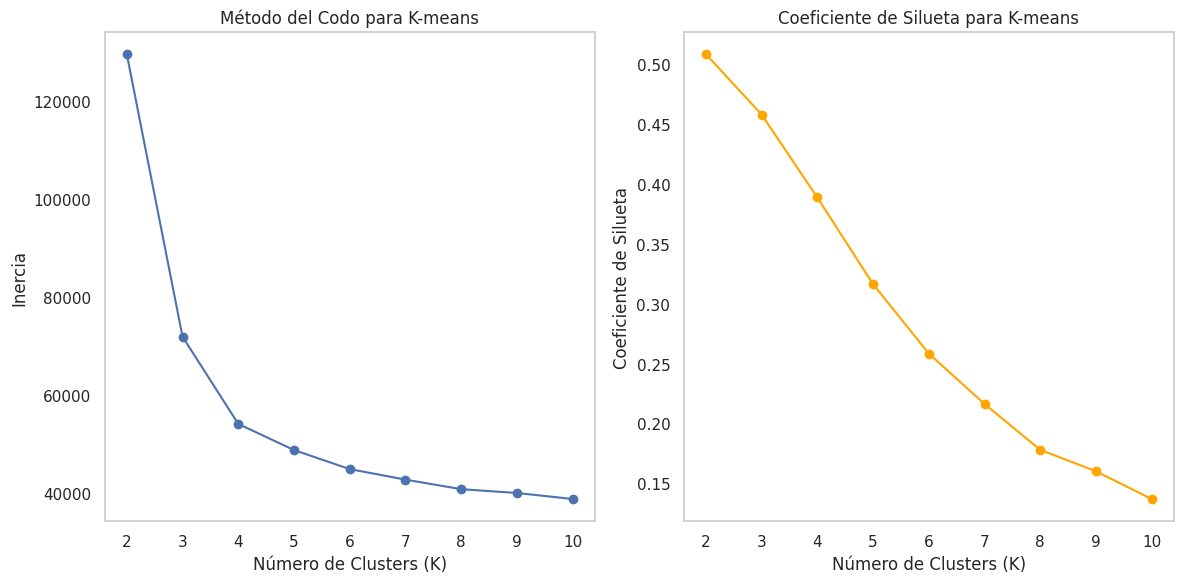

In [76]:
# Definir el rango de valores de K
K_range = range(2, 11)  # Empezar desde 2 porque el coeficiente de silueta no se puede calcular para 1
inertia_values = []
silhouette_values = []

# Calcular la inercia y el coeficiente de silueta para cada valor de K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_train)  # Asegúrate de que X_train esté definido

    inertia_values.append(kmeans.inertia_)

    # Calcular el coeficiente de silueta
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_values.append(silhouette_avg)

# Graficar el método del codo
plt.figure(figsize=(12, 6))

# Gráfico de inercia
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia_values, marker='o')
plt.title('Método del Codo para K-means')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.xticks(K_range)
plt.grid()

# Gráfico de silueta
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_values, marker='o', color='orange')
plt.title('Coeficiente de Silueta para K-means')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Coeficiente de Silueta')
plt.xticks(K_range)
plt.grid()

plt.tight_layout()
plt.show()

Método del Codo: El "codo" es el punto donde la reducción en la inercia comienza a desacelerarse, es decir, donde ya no hay una disminución significativa. En este grafico parece que el codo se encuentra alrededor de
K = 3 o K =4.

Coeficiente de Silueta: Este gráfico muestra que los valores de silueta son más altos para  K = 2 y k= 3 y disminuyen a medida que aumenta K. Un valor más alto indica una mejor agrupación.

En resumen, basándome en los gráficos el valor optimo de K parece ser 3.

In [82]:
# Definir el número de clusters optimo
k_optimo = 3

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Entrenar el modelo K-means en el conjunto de entrenamiento
kmeans = KMeans(n_clusters=k_optimo, random_state=0)
kmeans.fit(X_train_scaled)

# Predecir los clusters para el conjunto de entrenamiento y prueba
train_clusters = kmeans.predict(X_train_scaled)
#test_clusters = kmeans.predict(X_test)

# Agregar las etiquetas de clusters
X_train['Cluster'] = train_clusters
#X_test['Cluster'] = test_clusters

# Ver las primeras filas del conjunto de entrenamiento con la columna de cluster asignada
X_train.head()


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,Cluster
0,-0.221897,0,3.175960,1,1,17,-1.065128,-0.599444,0.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,-0.756773,0,-0.841116,1,0,20,-0.504040,-0.599444,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,-0.114922,0,-0.842163,1,0,26,0.727127,-0.222339,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,1.703655,0,0.423248,0,0,11,2.458832,-0.599444,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,-0.542822,0,-0.191141,1,0,6,-0.923847,-0.222339,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


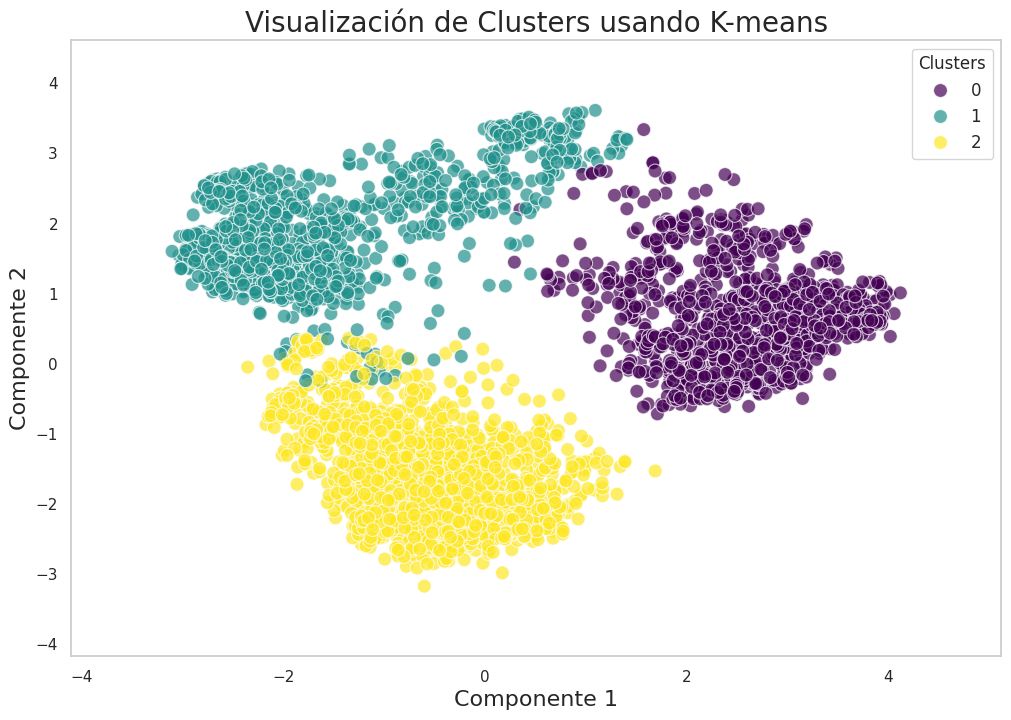

In [83]:
# Reducir la dimensionalidad a 2D para visualización
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train_scaled)

# Crear un DataFrame para facilitar la visualización
df_reduced = pd.DataFrame(data=X_train_reduced, columns=['Componente 1', 'Componente 2'])
df_reduced['Cluster'] = X_train['Cluster']

# Configurar el estilo del gráfico
sns.set(style="whitegrid")

# Crear el scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df_reduced, x='Componente 1', y='Componente 2',
                          hue='Cluster', palette='viridis', s=100, alpha=0.7, edgecolor='w')

# Ajustar límites de los ejes
plt.xlim(df_reduced['Componente 1'].min() - 1, df_reduced['Componente 1'].max() + 1)
plt.ylim(df_reduced['Componente 2'].min() - 1, df_reduced['Componente 2'].max() + 1)

# Añadir título y etiquetas
plt.title('Visualización de Clusters usando K-means', fontsize=20)
plt.xlabel('Componente 1', fontsize=16)
plt.ylabel('Componente 2', fontsize=16)

# Mostrar leyenda
plt.legend(title='Clusters', fontsize=12)
plt.grid()
plt.show()


##Interpretacion de los resultados:

La segmentación de clientes mediante machine learning permite a la empresa obtener insights valiosos que se alinean con sus objetivos de negocio.

Al analizar los tres clusters bien definidos, observamos grupos distintos de clientes que revelan diferencias significativas en comportamiento y características. Cada cluster puede representar un patrón de gasto diferente: por ejemplo, un grupo puede incluir clientes de alto gasto, mientras que otro puede abarcar a clientes más conservadores. Esta segmentación ayuda a identificar nichos de mercado y oportunidades para lanzar nuevos productos adaptados a cada grupo, **lo que responde al objetivo de mejorar la personalización de ofertas y campañas de marketing**.

La existencia de clusters bien definidos indica que la segmentación ha sido exitosa, permitiendo a la empresa implementar estrategias personalizadas. Esto está directamente relacionado con el objetivo de **optimizar la asignación de recursos y maximizar el retorno de la inversión a través de campañas dirigidas y ajustadas a las necesidades de cada segmento**.

Con esta información, la empresa puede adaptar sus productos y servicios para maximizar su atractivo. Esto facilita la personalización de campañas, creando mensajes y ofertas que resuenen con cada grupo, lo que mejora la tasa de respuesta y efectividad de las campañas. Al comprender mejor las necesidades de cada cluster, la empresa puede innovar en su oferta y desarrollar productos que satisfagan específicamente a cada segmento, incrementando así su cuota de mercado, lo que se alinea con el objetivo de **aumentar la retención de clientes**.

Finalmente, la capacidad de ajustar estrategias y productos según la evolución del comportamiento de los clientes asegurará que la empresa se mantenga relevante y competitiva en el mercado.
